In [82]:
import shap
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec

In [83]:
train_full = pd.read_csv("./data/base/train-white.csv", sep=",")
test_full = pd.read_csv("./data/base/test-white.csv", sep=",")

In [84]:
target = "quality"
model_name = "rf"

In [85]:
with open('./model/selected-{}.pickle'.format(model_name), 'rb') as f:
    model = pickle.load(f)

In [86]:
X_train = copy.deepcopy(train_full.drop(columns=target))
X_test = copy.deepcopy(test_full.drop(columns=target))
y_train = train_full[target]
y_test = test_full[target]

In [87]:
preperation_model = copy.deepcopy(model)
preperation_model.steps.pop(-1)

('rf', RandomForestClassifier(max_depth=20, random_state=0))

In [106]:
X_test_prepared_arr = preperation_model.transform(X_test)

In [107]:
X_test_prepared = pd.DataFrame(X_test_prepared_arr, columns=X_train.columns)

In [177]:
features = X_train.columns.tolist()

In [89]:
explainer = shap.TreeExplainer(model[model_name])

In [174]:
classes = model[model_name].classes_.tolist()

In [203]:
shap_values = explainer.shap_values(X_test_prepared)

In [93]:
shap_interaction_values = explainer.shap_interaction_values(X_test_prepared)

In [205]:
from MongoShapHandler5 import MongoShapHandler

mongo_shap_handler = MongoShapHandler("selection", model_name)

In [206]:
mongo_shap_handler.store_shap_meta("", classes, features)

In [208]:
for class_index, shap_class_values in enumerate(shap_values):
    for value_index, my_shap_values in enumerate(shap_class_values):
        interactions = {}
        for int_index, interaction in enumerate(shap_interaction_values[class_index][value_index]):
            interactions[str(int_index)] = interaction.tolist()
        mongo_shap_handler.store_shap(classes[class_index], value_index, my_shap_values.tolist(), interactions)

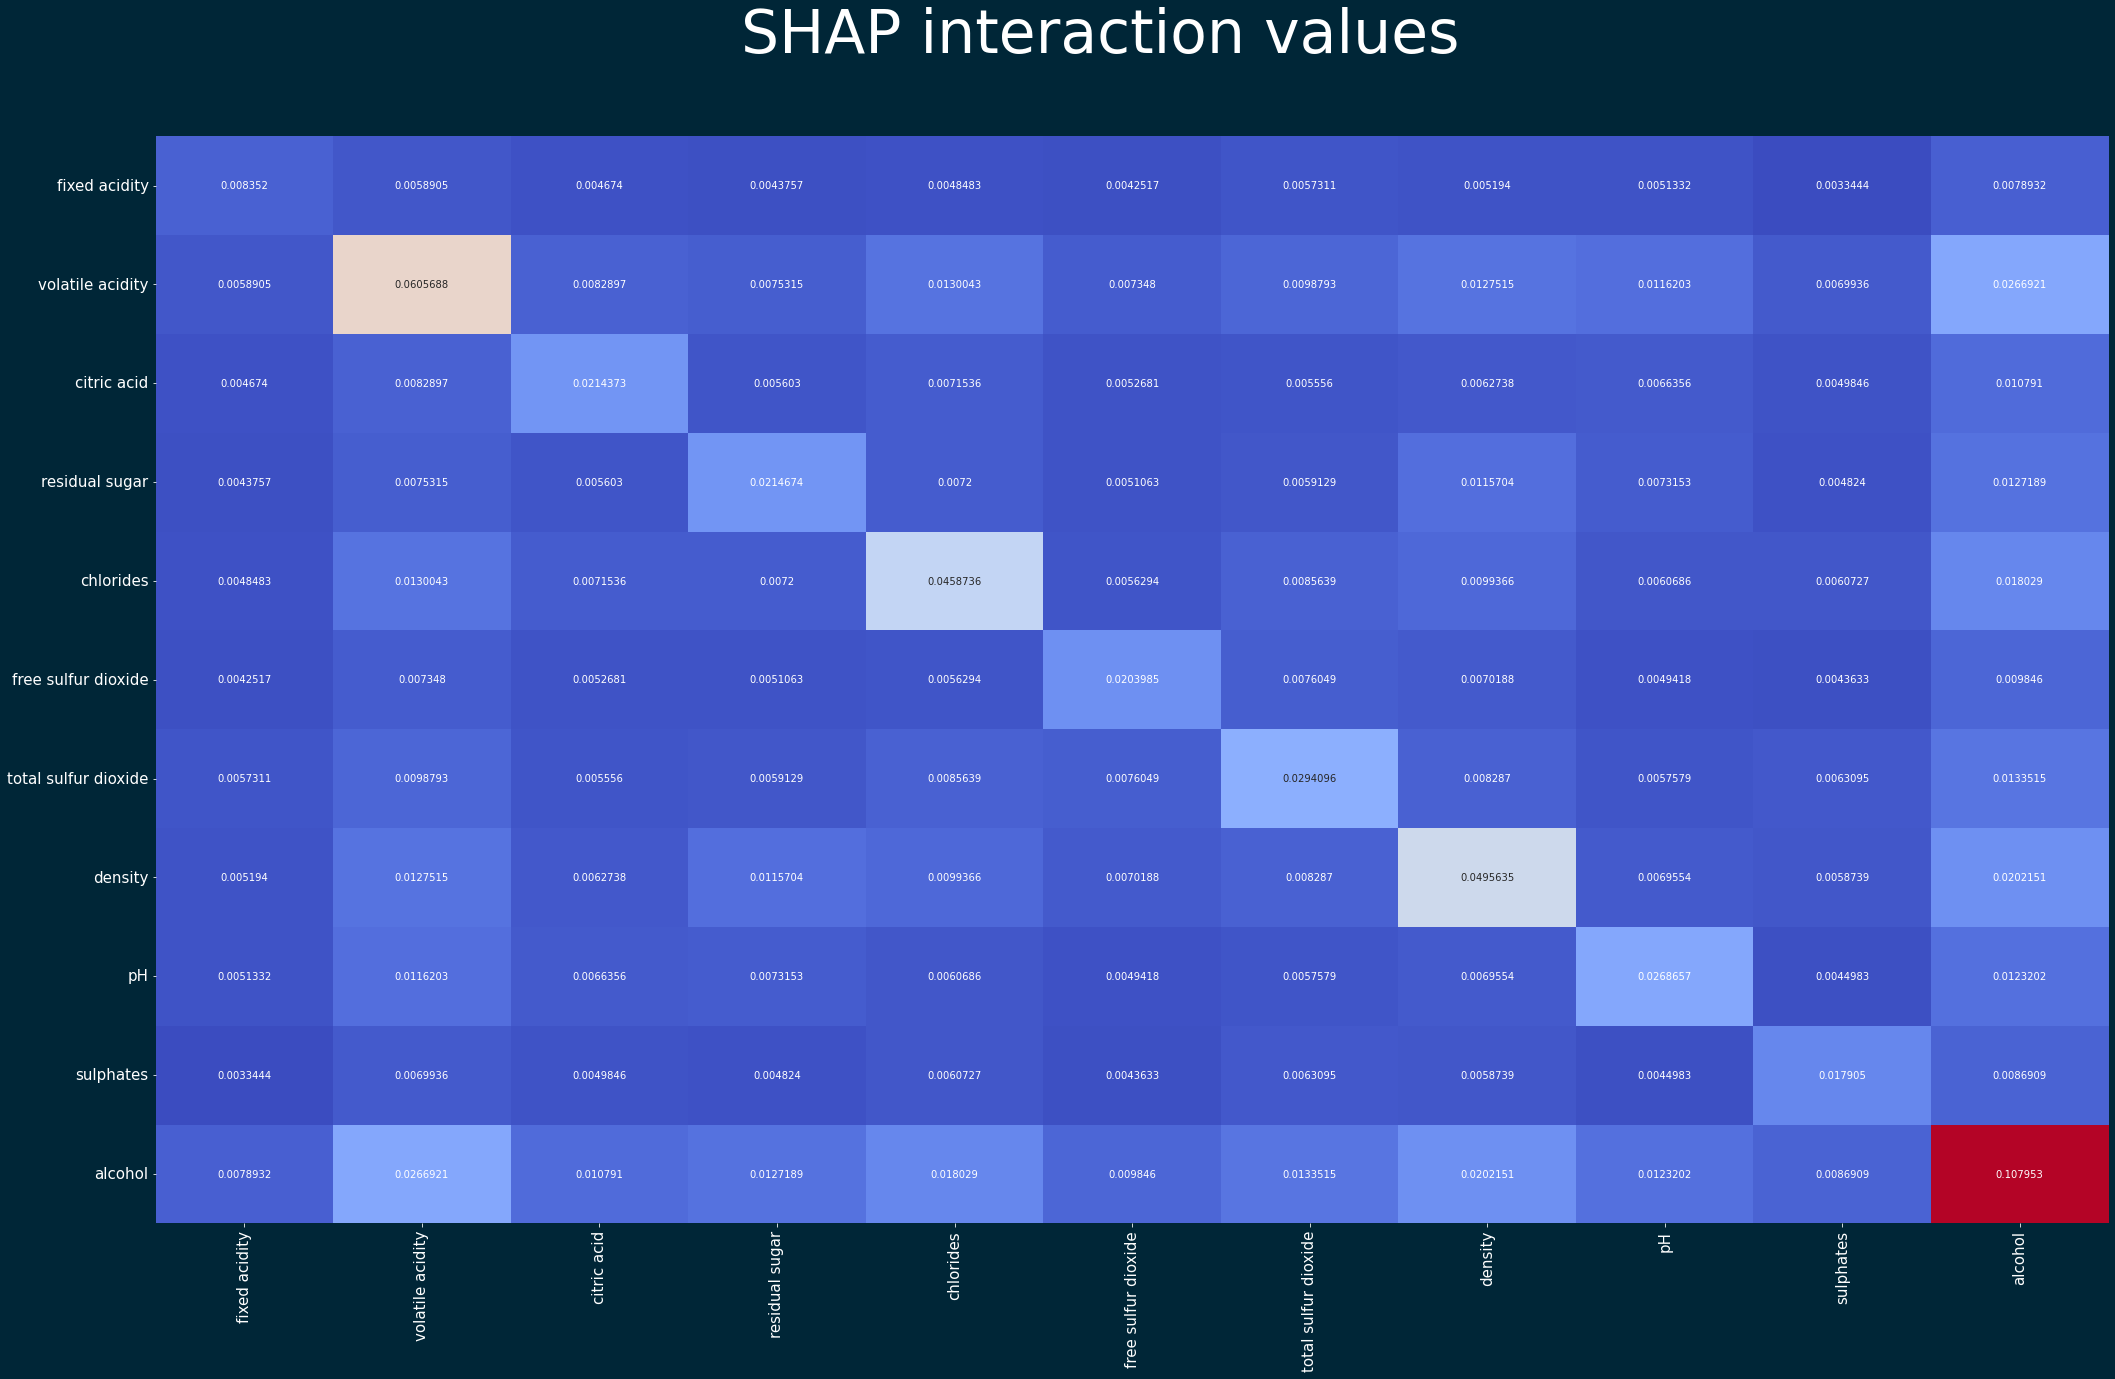

In [164]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction_values[2]).mean(0)
df = pd.DataFrame(mean_shap, index=X_test_prepared.columns, columns=X_test_prepared.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=7), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

In [162]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,0.008352,0.005885,0.004672,0.004374,0.004847,0.004251,0.005728,0.005192,0.005131,0.003344,0.007889
volatile acidity,0.005885,0.060569,0.008275,0.007522,0.012984,0.007345,0.009876,0.012746,0.011619,0.006981,0.026667
citric acid,0.004672,0.008275,0.021437,0.005597,0.007144,0.005262,0.005550,0.006272,0.006633,0.004983,0.010779
residual sugar,0.004374,0.007522,0.005597,0.021467,0.007195,0.005105,0.005906,0.011570,0.007312,0.004822,0.012711
chlorides,0.004847,0.012984,0.007144,0.007195,0.045874,0.005629,0.008556,0.009923,0.006067,0.006073,0.018001
free sulfur dioxide,0.004251,0.007345,0.005262,0.005105,0.005629,0.020399,0.007599,0.007015,0.004936,0.004358,0.009843
total sulfur dioxide,0.005728,0.009876,0.005550,0.005906,0.008556,0.007599,0.029410,0.008274,0.005757,0.006307,0.013334
density,0.005192,0.012746,0.006272,0.011570,0.009923,0.007015,0.008274,0.049564,0.006950,0.005861,0.020199
pH,0.005131,0.011619,0.006633,0.007312,0.006067,0.004936,0.005757,0.006950,0.026866,0.004495,0.012316
sulphates,0.003344,0.006981,0.004983,0.004822,0.006073,0.004358,0.006307,0.005861,0.004495,0.017905,0.008681


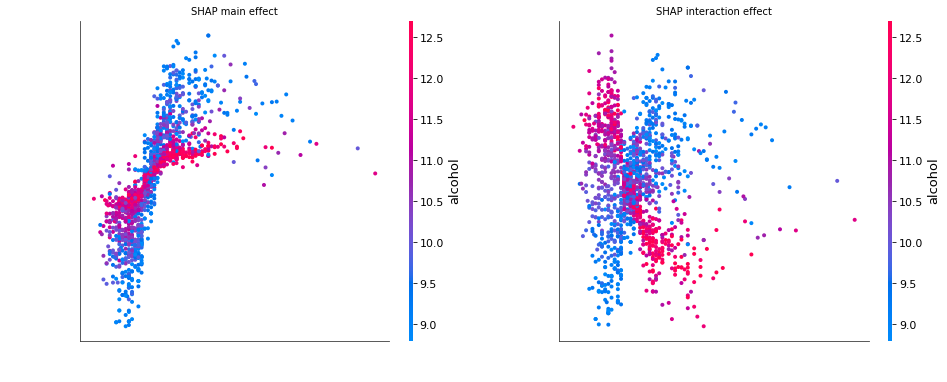

In [146]:


#plot feature interaction
def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    shap.dependence_plot(f1, shap_values[2], X_test, display_features=X_test, interaction_index=f2, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction_values[2], X_test, display_features=X_test, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)
    fig.tight_layout()

    plt.show()

# plt.style.use("cyberpunk")

f1='volatile acidity'
f2='alcohol'
plot_feature_interaction(f1, f2)



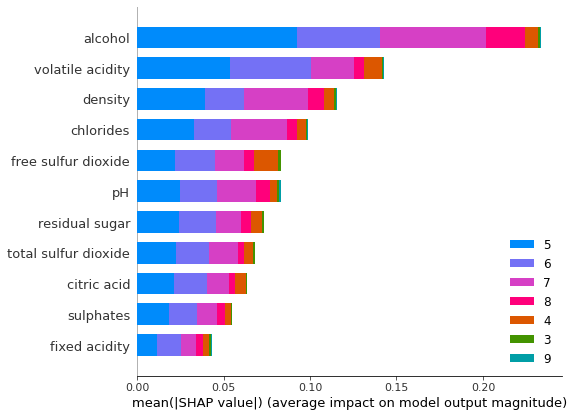

In [145]:
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=["3", "4", "5", "6", "7", "8", "9"], feature_names = X_train.columns)